Imports

In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional, Embedding
from scipy.stats import pearsonr
from keras_self_attention import SeqSelfAttention
import numpy as np
import pandas as pd
import time

In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.fillna(0, inplace=True)
    return agg

### Initial Preprocessing

In [4]:
#from pandas import read_csv
data = pd.read_csv('/home/shreevidya/Data/combined_cleaned.csv')
data.head()
#data = data.drop('No', axis=1, inplace=False)

,pollution,dew,temp,press,wnd_spd,RH,WD,VWS,SR
0,83.70,32.036,32.98,1032.59,0.57,95.28,144.36,0.57,1.57
1,89.85,26.636,27.58,1031.50,0.57,95.28,143.09,0.57,1.53
2,88.47,26.618,27.56,1030.86,0.57,95.29,145.10,0.57,1.61
3,78.02,26.616,27.56,1030.15,0.57,95.28,141.00,0.57,1.58
4,66.91,32.036,32.98,1029.90,0.57,95.28,141.76,0.57,1.50


In [5]:
#data = data.drop(data.columns[6:78], axis=1, inplace=False)

In [6]:
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'RH', 'WD', 'VWS', 'SR']

In [7]:
# mark all NA values with 0
#data['PM2.5'].fillna(0, inplace=True)
# drop the first 24 hours
#data = data[24:]
# summarize first 5 rows
#print(data.head(5))
# save to file
#data.to_csv('pollution_nolanduse.csv')

In [8]:
# mark all NA values with 0
data['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
data = data[24:]
# summarize first 5 rows
print(data.head(5))
# save to file
data.to_csv('pollution1.csv')

    pollution     dew   temp    press  wnd_spd     RH      WD   VWS   SR
24      81.74  23.738  27.12  1034.05     0.57  83.09  165.10  0.57  1.5
25      70.74  24.666  27.56  1032.92     0.58  85.53  153.24  0.58  1.5
26      70.58  25.402  27.56  1032.21     0.58  89.21  141.23  0.58  1.5
27      65.74  26.634  27.58  1032.05     0.59  95.27  147.66  0.59  1.5
28      33.29  26.174  27.12  1032.42     0.59  95.27  150.38  0.59  1.5


## Baseline LSTM + room to change network architecture

In [9]:
# load dataset
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
print(dataset.columns)
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
print(values.shape)
# normalize features (after I reframe into a supervised learning problem)
# frame as supervised learning -
####### Can change t_input timesteps here ##########  ### I changed it to time lag = 4
reframed = series_to_supervised(values, 1, 1, True)
print(reframed.shape)
# drop columns we don't want to predict
reframed.drop(reframed.columns[10:18], axis=1, inplace=True)
#print(reframed.head())

# split into train and test sets
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))

n_train_hours = 60000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Bidirectional(LSTM(units=128, return_sequences=True), input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(SeqSelfAttention(
#    attention_width=15,
 #   attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
  #  attention_activation=None))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'RH', 'WD', 'VWS',
       'SR'],
      dtype='object')
(84600, 9)
(84600, 18)
(60000, 1, 9) (60000,) (24600, 1, 9) (24600,)


In [10]:
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)    var4(t-1)  var5(t-1)  var6(t-1)  \
0   0.000000   0.000000   0.000000     0.000000       0.00   0.000000   
1  81.739998  23.738001  27.120001  1034.050049       0.57  83.089996   
2  70.739998  24.666000  27.559999  1032.920044       0.58  85.529999   
3  70.580002  25.402000  27.559999  1032.209961       0.58  89.209999   
4  65.739998  26.634001  27.580000  1032.050049       0.59  95.269997   

    var7(t-1)  var8(t-1)  var9(t-1)    var1(t)  
0    0.000000       0.00        0.0  81.739998  
1  165.100006       0.57        1.5  70.739998  
2  153.240005       0.58        1.5  70.580002  
3  141.229996       0.58        1.5  65.739998  
4  147.660004       0.59        1.5  33.290001  


### Train and Test Neural Network

Epoch 1/100
834/834 [==============================] - 7s 9ms/step - loss: 0.0156 - val_loss: 0.0130
Epoch 2/100
834/834 [==============================] - 6s 7ms/step - loss: 0.0106 - val_loss: 0.0136
Epoch 3/100
834/834 [==============================] - 8s 9ms/step - loss: 0.0103 - val_loss: 0.0123
Epoch 4/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0100 - val_loss: 0.0126
Epoch 5/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0099 - val_loss: 0.0122
Epoch 6/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0099 - val_loss: 0.0119
Epoch 7/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0098 - val_loss: 0.0117
Epoch 8/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0097 - val_loss: 0.0117
Epoch 9/100
834/834 [==============================] - 8s 10ms/step - loss: 0.0096 - val_loss: 0.0116
Epoch 10/100
834/834 [==============================] - 9s 11ms/step - loss: 0.0097 -

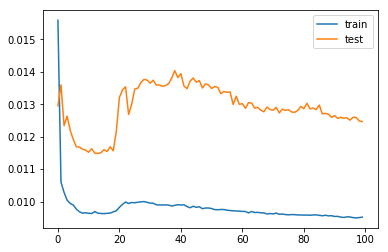

This took 915.7139329910278 seconds.
Test RMSE: 33.891


In [11]:
start = time.time()

# fit network
###################### Can change Epochs, Batch size here #######################
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), 
                    verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
end = time.time()
print('This took {} seconds.'.format(end - start))
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE of 25.654 on best run

### Plot Predicted vs. Actual and Calculate Errors

In [12]:
import matplotlib
from matplotlib import pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [22]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 100 epochs of training')
    ax.plot(true_data, label='True Data', color='green')
    ax.plot(predicted_data, label='Prediction', color='red')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration $(\mu g / m^3)$')
    plt.legend()
    plt.savefig("lstm.pdf")
    plt.show()

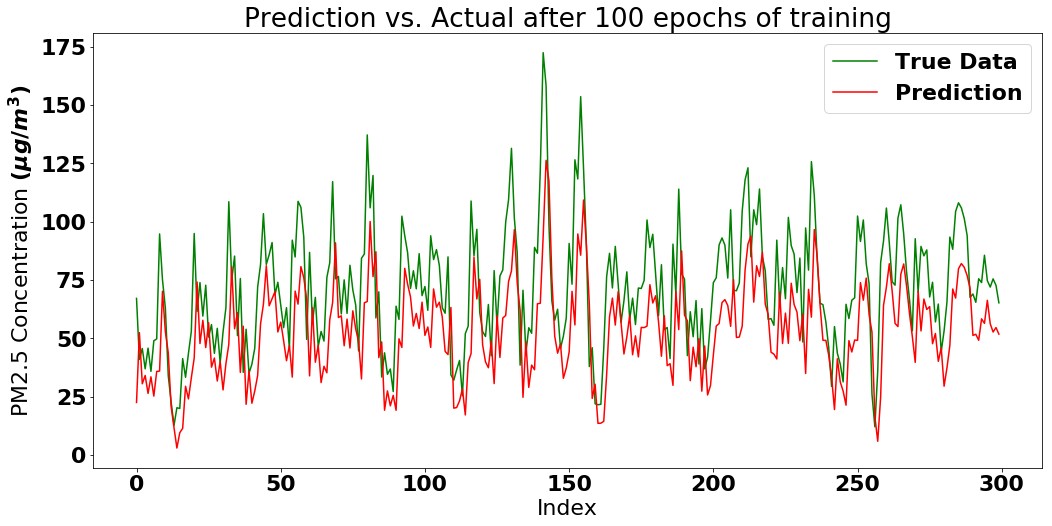

In [23]:
plot_predicted(inv_yhat[400:700,], inv_y[400:700,])

In [15]:
print('Root Mean Squared Error: {:.4f}'.format(rmse))

#Calculate R^2 (regression score function)
#print('Variance score: %.2f' % r2_score(y, data_pred))
print('Variance score: {:2f}'.format(r2_score(inv_y, inv_yhat)))

Root Mean Squared Error: 33.8914
Variance score: 0.473948


In [16]:
corr, _ = pearsonr(inv_y, inv_yhat)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.712
